In [1]:
import zipfile
import os

# Specify the path to the ZIP file
zip_file_path = 'cnn_dataset.zip'

# Specify the directory where you want to extract the contents of the ZIP file
extracted_dir_path = os.path.join(os.path.dirname(zip_file_path), 'cnn_dataset')

# Create the directory if it does not exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Print a message indicating that the extraction is complete
print("Extraction complete.")

Extraction complete.


In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preprocessing
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Random resized crop
    transforms.Resize(256),  # Resize to 256x256
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Specify the path to the dataset
#dataset_path = 'cnn_dataset'

# Load the dataset
dataset = datasets.ImageFolder(root=extracted_dir_path, transform=data_transform)

# Print dataset statistics
print("Number of classes:", len(dataset.classes))
print("Class names:", dataset.classes)
print("Number of images:", len(dataset))

# Data split
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Define data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print main statistics about the dataset
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of classes: 3
Class names: ['dogs', 'food', 'vehicles']
Number of images: 30000
Number of training samples: 21000
Number of validation samples: 4500
Number of testing samples: 4500


In [17]:
import torch
import torch.nn as nn

# Define the basic residual block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.stride = stride

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Shortcut connection
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define the ResNet-18 architecture
class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Define the ResNet-18 model
def ResNet18_custom():
    return ResNet18(BasicBlock, [2, 2, 2, 2])

# Instantiate the ResNet-18 model
model = ResNet18_custom()


Epoch [1/10], Train Loss: 0.7209, Train Acc: 0.7000, Val Loss: 0.7497, Val Acc: 0.7020
Epoch [2/10], Train Loss: 0.5914, Train Acc: 0.7577, Val Loss: 0.5378, Val Acc: 0.7947
Epoch [3/10], Train Loss: 0.5377, Train Acc: 0.7840, Val Loss: 0.5423, Val Acc: 0.7913
Epoch [4/10], Train Loss: 0.5060, Train Acc: 0.7978, Val Loss: 0.4306, Val Acc: 0.8311
Epoch [5/10], Train Loss: 0.4663, Train Acc: 0.8162, Val Loss: 0.4377, Val Acc: 0.8258
Epoch [6/10], Train Loss: 0.4252, Train Acc: 0.8342, Val Loss: 0.4464, Val Acc: 0.8204
Epoch [7/10], Train Loss: 0.4003, Train Acc: 0.8443, Val Loss: 0.4117, Val Acc: 0.8427
Epoch [8/10], Train Loss: 0.3809, Train Acc: 0.8511, Val Loss: 0.3301, Val Acc: 0.8722
Epoch [9/10], Train Loss: 0.3604, Train Acc: 0.8593, Val Loss: 0.4842, Val Acc: 0.8209
Epoch [10/10], Train Loss: 0.3428, Train Acc: 0.8677, Val Loss: 0.3135, Val Acc: 0.8858


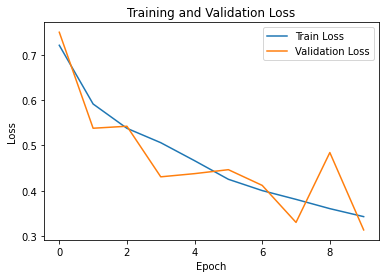

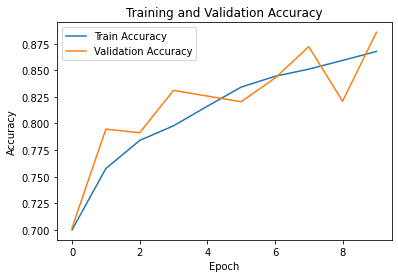

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate accuracy
def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

# Function to train the model
def train_model(model, train_loader, val_loader, num_epochs=3, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        total_train_accuracy = 0.0
        total_train_samples = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)
            total_train_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
            total_train_samples += inputs.size(0)

        epoch_train_loss = running_train_loss / total_train_samples
        epoch_train_accuracy = total_train_accuracy / total_train_samples
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        model.eval()
        running_val_loss = 0.0
        total_val_accuracy = 0.0
        total_val_samples = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs.size(0)
                total_val_accuracy += calculate_accuracy(outputs, labels) * inputs.size(0)
                total_val_samples += inputs.size(0)

        epoch_val_loss = running_val_loss / total_val_samples
        epoch_val_accuracy = total_val_accuracy / total_val_samples
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}')

    # Plotting loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plotting accuracy
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001)
